In [ ]:
# Chang: this is the minimal packages required
%%capture
!pip install 'transformers[torch,sklearn]==4.37.1' matplotlib umap-learn==0.5.1 datasets==2.15 numpy==1.23.4 pyarrow==14.0.2

In [1]:
import warnings
import logging

import numpy as np

In [2]:
# Disable huggingface nonsense
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

# Text Classification

Sentiment analysis is perhaps the most common use case for text classification. Let's try it out here with an open dataset.

## The Dataset

In [3]:
# Chang: This example is taken from the Huggingface O'Reilly book, but the emotion dataset has been removed.
# Here we use use https://huggingface.co/datasets/SetFit/emotion?library=true
from datasets import load_dataset

emotions = load_dataset("SetFit/emotion")

Generating train split: 16000 examples [00:00, 1044658.53 examples/s]
Generating validation split: 2000 examples [00:00, 403298.46 examples/s]
Generating test split: 2000 examples [00:00, 458494.10 examples/s]


In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions["train"]
print(train_ds)
print(len(train_ds))
print(train_ds[0])

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 16000
})
16000
{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}


In [6]:
train_ds.column_names

['text', 'label', 'label_text']

In [7]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'label_text': Value(dtype='string', id=None)}


In [8]:
# Chang: use pprint for multi line prints
import pprint

pprint.pprint(train_ds["text"][:5])

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being '
 'around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still '
 'on the property',
 'i am feeling grouchy']


### From Datasets to DataFrames

In [9]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [10]:
df.describe(include='object')

,text,label_text
count,16000,16000
unique,15969,6
top,i feel on the verge of tears from weariness i ...,joy
freq,2,5362


In [11]:
emotions.reset_format()

### Looking at the Class Distribution

There are a lot of problems with the dataset itself, but we will ignore it. 

For example, read this if you are curious -> https://koaning.io/posts/labels/

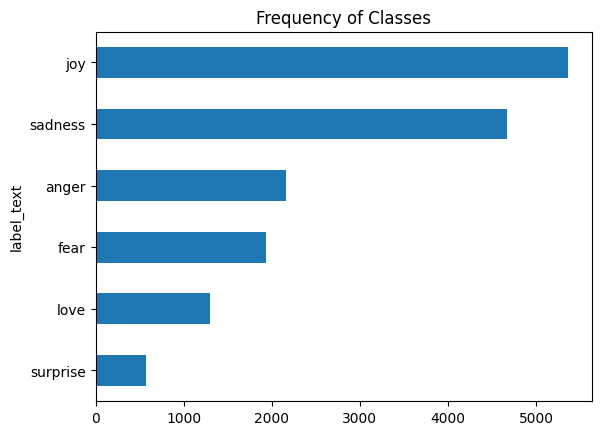

In [13]:
import matplotlib.pyplot as plt

df["label_text"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [ ]:
def shit_model(text):
  return 0

In [ ]:
5000 / 16000

0.3125

**Question**: what is the baseline model that we're comparing with in this case?

## From Text to Tokens

### Subword Tokenization

In [ ]:
from transformers import AutoTokenizer

MODEL = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

text = "Text classification is one of the most common tasks in NLP."
encoded_text = tokenizer(text)
pprint.pprint(encoded_text)

tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

# save it for later
distilbert_tokenizer = tokenizer

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101,
               3793,
               5579,
               2003,
               2028,
               1997,
               1996,
               2087,
               2691,
               8518,
               1999,
               17953,
               2361,
               1012,
               102]}
['[CLS]', 'text', 'classification', 'is', 'one', 'of', 'the', 'most', 'common', 'tasks', 'in', 'nl', '##p', '.', '[SEP]']


What if we tokenize some Japanese?

In [ ]:
print(tokenizer.convert_ids_to_tokens(tokenizer("O-negai shimasu").input_ids))

['[CLS]', 'o', '-', 'ne', '##gai', 'shi', '##mas', '##u', '[SEP]']


In [ ]:
print(tokenizer.convert_ids_to_tokens(tokenizer("🙄").input_ids))

['[CLS]', '[UNK]', '[SEP]']


Because this model's tokenizer encodes "🙄" as a `[UNK]` token, whenever it encounters this emoji, it is treated as a `[UNK]` along with other characters that are unknown to the tokenizer.

What if we use `microsoft/deberta-v3-small`?

In [ ]:
# MODEL = "microsoft/deberta-v3-small"
MODEL = "microsoft/deberta-v3-xsmall"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

text = "Text classification is one of the most common tasks in NLP."
encoded_text = tokenizer(text)
pprint.pprint(encoded_text)

tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

# save it for later
deberta_tokenizer = tokenizer

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [1,
               7655,
               9209,
               269,
               311,
               265,
               262,
               370,
               1019,
               3344,
               267,
               40903,
               260,
               2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
['[CLS]', '▁Text', '▁classification', '▁is', '▁one', '▁of', '▁the', '▁most', '▁common', '▁tasks', '▁in', '▁NLP', '.', '[SEP]']


In [ ]:
print(tokenizer.convert_ids_to_tokens(tokenizer("O-negai shimasu").input_ids))

['[CLS]', '▁O', '-', 'ne', 'gai', '▁shim', 'asu', '[SEP]']


In [ ]:
print(tokenizer.convert_ids_to_tokens(tokenizer("🙄").input_ids))

['[CLS]', '▁', '🙄', '[SEP]']


### Special tokens

In [ ]:
print(distilbert_tokenizer.all_special_tokens)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']


In [ ]:
print(deberta_tokenizer.all_special_tokens)

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']


The `AutoTokenizer` class also has several attributes that provide information about the tokenizer. For example, we can inspect the vocabulary size:

In [ ]:
print(distilbert_tokenizer.vocab_size)

30522


In [ ]:
print(deberta_tokenizer.vocab_size)

128000


and the corresponding model's maximum context size:

In [ ]:
distilbert_tokenizer.model_max_length

512

In [ ]:
# See https://github.com/huggingface/transformers/issues/16998#issuecomment-1183941501
deberta_tokenizer.model_max_length

1000000000000000019884624838656

Another interesting attribute to know about is the names of the fields that the model expects in its forward pass:

### Tokenizing the Whole Dataset

In [ ]:
def tokenize(batch):
    # need to add tolist() because this dataset uses pandas Series, which is unsupported by Huggingface dataset
    # Somehow not an issue in the last lecture?
    return tokenizer(batch["text"])

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
print(emotions.column_names)

{'train': ['text', 'label', 'label_text'], 'validation': ['text', 'label', 'label_text'], 'test': ['text', 'label', 'label_text']}


In [ ]:
emotions_encoded['train'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'label_text': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [ ]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[1, 584, 16965, 551, 41064, 2], [1, 584, 295, 424, 292, 1439, 324, 22328, 264, 324, 21496, 11357, 348, 292, 411, 441, 760, 328, 11416, 263, 269, 11133, 2]], 'token_type_ids': [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


## Training a Text Classifier

#### Using pretrained models

In [ ]:
import torch
from transformers import AutoModel

# from last lecture, let's write it here if we need it
# tiny_model = "prajjwal1/bert-tiny"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModel.from_pretrained(MODEL).to(device)


pytorch_model.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

### Fine-Tuning Transformers

#### Loading a pretrained model

In [ ]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
        #  .from_pretrained(model_ckpt, num_labels=num_labels)
         .from_pretrained(MODEL, num_labels=num_labels)
         .to(device))

#### Defining the performance metrics


To monitor metrics during training, we need to define a `compute_metrics()` function for the `Trainer`.  This function receives an `EvalPrediction` object (which is a named tuple with `predictions` and `label_ids` attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the $F_1$-score and the accuracy of the model as follows:

**Discussion**: loss and metrics

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Discussion: why weighted?
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Training the model

To define the training parameters, we use the `TrainingArguments` class.

**Question**: what about all those parameters? What should I use?

In [ ]:
from transformers import Trainer, TrainingArguments

bs = 128
lr = 8e-5
epochs=4

# I used args from fast.ai's course
# https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners
model_name = f"{MODEL}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=epochs,
    learning_rate=lr,
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs*2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    # warmup in deep learning: https://datascience.stackexchange.com/questions/55991/in-the-context-of-deep-learning-what-is-training-warmup-steps
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    fp16=True,
    log_level="error",
    report_to='none',
    )

Here we also set the batch size, learning rate, and number of epochs, and specify to load the best model at the end of the training run. With this final ingredient, we can instantiate and fine-tune our model with the `Trainer`:

In [ ]:
# # this is slow as hell with CPU
# Two choices - use GPU or TPU if you are using Google Colab. For CPU, use a subset of data to make sure our code works first
# before starting the training loop
%%time
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

{'eval_loss': 0.2714540362358093, 'eval_accuracy': 0.9155, 'eval_f1': 0.9169682223956164, 'eval_runtime': 1.1512, 'eval_samples_per_second': 1737.359, 'eval_steps_per_second': 6.949, 'epoch': 1.0}
{'eval_loss': 0.1786629557609558, 'eval_accuracy': 0.933, 'eval_f1': 0.9336422319727324, 'eval_runtime': 1.1291, 'eval_samples_per_second': 1771.354, 'eval_steps_per_second': 7.085, 'epoch': 2.0}
{'eval_loss': 0.1498289853334427, 'eval_accuracy': 0.936, 'eval_f1': 0.9362557379179465, 'eval_runtime': 1.4419, 'eval_samples_per_second': 1387.033, 'eval_steps_per_second': 5.548, 'epoch': 3.0}
{'loss': 0.1962, 'learning_rate': 9.747717842101268e-10, 'epoch': 4.0}
{'eval_loss': 0.1410776972770691, 'eval_accuracy': 0.937, 'eval_f1': 0.9372737362954231, 'eval_runtime': 1.2214, 'eval_samples_per_second': 1637.458, 'eval_steps_per_second': 6.55, 'epoch': 4.0}
{'train_runtime': 142.4004, 'train_samples_per_second': 449.437, 'train_steps_per_second': 3.511, 'train_loss': 0.19616619873046875, 'epoch': 4.0

TrainOutput(global_step=500, training_loss=0.19616619873046875, metrics={'train_runtime': 142.4004, 'train_samples_per_second': 449.437, 'train_steps_per_second': 3.511, 'train_loss': 0.19616619873046875, 'epoch': 4.0})

Let's check confusion matrix for the training process -- we will use the validation dataset

In [ ]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

The output of the `predict()` method is a `PredictionOutput` object that contains arrays of `predictions` and `label_ids`, along with the metrics we passed to the trainer. For example, the metrics on the validation set can be accessed as follows:

In [ ]:
# hide_output
test_set_output = trainer.predict(emotions_encoded["test"])

In [ ]:
test_set_output.metrics

{'test_loss': 0.1602264642715454,
 'test_accuracy': 0.9275,
 'test_f1': 0.9275264585095374,
 'test_runtime': 1.5393,
 'test_samples_per_second': 1299.279,
 'test_steps_per_second': 5.197}

It also contains the raw predictions for each class. We can decode the predictions greedily using `np.argmax()`. This yields the predicted labels and has the same format as the labels returned by the Scikit-Learn models in the feature-based approach:

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(emotions["validation"]["label"])

With the predictions, we can plot the confusion matrix again:

In [ ]:
max(y_preds)

5

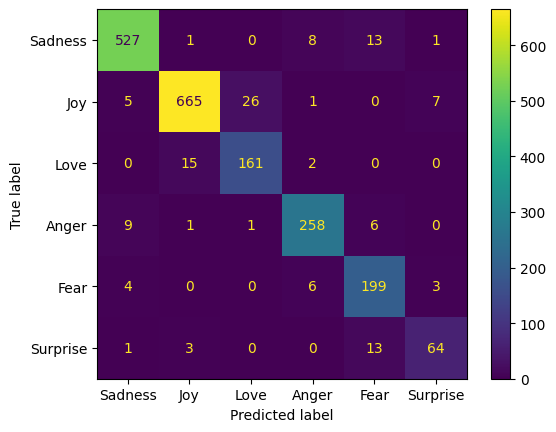

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

LABELS = [0,1,2,3,4,5]
LABEL_NAMES = ["Sadness", "Joy", "Love", "Anger", "Fear", "Surprise"]

cm = confusion_matrix(y_valid, y_preds, labels=LABELS)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
disp.plot()
plt.show()

#### Saving the model

In [ ]:
# Save to my_model directory
trainer.save_model(output_dir='./my_model')

We can also use the fine-tuned model to make predictions on new tweets. Since we've pushed our model to the Hub, we can now use it with the `pipeline()` function, just like we did in <<chapter_introduction>>. First, let's load the pipeline:

In [ ]:
# Loading model from local
from transformers import pipeline

classifier = pipeline("text-classification", model='./my_model')

Then let's test the pipeline with a sample tweet:

In [ ]:
custom_tweet = "😭"
preds = classifier(custom_tweet, return_all_scores=True)

In [ ]:
LABEL_NAMES

['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']

In [ ]:
preds

[[{'label': 'LABEL_0', 'score': 0.015794401988387108},
  {'label': 'LABEL_1', 'score': 0.03647054731845856},
  {'label': 'LABEL_2', 'score': 0.0015463634626939893},
  {'label': 'LABEL_3', 'score': 0.703462541103363},
  {'label': 'LABEL_4', 'score': 0.2388700544834137},
  {'label': 'LABEL_5', 'score': 0.0038560647517442703}]]

In [ ]:
# Report metric on test set

## Suggestion: train a few times

Let's train again -- see what happens

In [ ]:
# Discussion: What is wrong here??
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

{'eval_loss': 0.19271422922611237, 'eval_accuracy': 0.93, 'eval_f1': 0.9309576095920175, 'eval_runtime': 1.4262, 'eval_samples_per_second': 1402.282, 'eval_steps_per_second': 5.609, 'epoch': 1.0}
{'eval_loss': 0.19015516340732574, 'eval_accuracy': 0.9335, 'eval_f1': 0.9343137107312642, 'eval_runtime': 1.2081, 'eval_samples_per_second': 1655.494, 'eval_steps_per_second': 6.622, 'epoch': 2.0}
{'eval_loss': 0.17652326822280884, 'eval_accuracy': 0.937, 'eval_f1': 0.9372654884206879, 'eval_runtime': 1.2009, 'eval_samples_per_second': 1665.39, 'eval_steps_per_second': 6.662, 'epoch': 3.0}
{'loss': 0.0879, 'learning_rate': 0.0, 'epoch': 4.0}
{'eval_loss': 0.1626509428024292, 'eval_accuracy': 0.9325, 'eval_f1': 0.9324427185296483, 'eval_runtime': 1.3173, 'eval_samples_per_second': 1518.217, 'eval_steps_per_second': 6.073, 'epoch': 4.0}
{'train_runtime': 141.7201, 'train_samples_per_second': 451.594, 'train_steps_per_second': 3.528, 'train_loss': 0.08788275146484376, 'epoch': 4.0}


In [ ]:
# try again
model = (AutoModelForSequenceClassification
        #  .from_pretrained(model_ckpt, num_labels=num_labels)
         .from_pretrained(MODEL, num_labels=num_labels)
         .to(device))
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

{'eval_loss': 0.8214609622955322, 'eval_accuracy': 0.7, 'eval_f1': 0.6287890579592751, 'eval_runtime': 1.2716, 'eval_samples_per_second': 1572.857, 'eval_steps_per_second': 6.291, 'epoch': 1.0}
{'eval_loss': 0.3042113482952118, 'eval_accuracy': 0.908, 'eval_f1': 0.9091049398119162, 'eval_runtime': 1.1381, 'eval_samples_per_second': 1757.323, 'eval_steps_per_second': 7.029, 'epoch': 2.0}
{'eval_loss': 0.198240727186203, 'eval_accuracy': 0.9305, 'eval_f1': 0.9310638903242162, 'eval_runtime': 1.1436, 'eval_samples_per_second': 1748.893, 'eval_steps_per_second': 6.996, 'epoch': 3.0}
{'loss': 0.5622, 'learning_rate': 9.747717842101268e-10, 'epoch': 4.0}
{'eval_loss': 0.18188872933387756, 'eval_accuracy': 0.9335, 'eval_f1': 0.9338560372760066, 'eval_runtime': 1.2267, 'eval_samples_per_second': 1630.453, 'eval_steps_per_second': 6.522, 'epoch': 4.0}
{'train_runtime': 151.2584, 'train_samples_per_second': 423.117, 'train_steps_per_second': 3.306, 'train_loss': 0.5622389526367187, 'epoch': 4.0}

In [ ]:
# try again
model = (AutoModelForSequenceClassification
         .from_pretrained(MODEL, num_labels=num_labels)
         .to(device))
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

{'eval_loss': 0.8214609622955322, 'eval_accuracy': 0.7, 'eval_f1': 0.6287890579592751, 'eval_runtime': 1.1613, 'eval_samples_per_second': 1722.231, 'eval_steps_per_second': 6.889, 'epoch': 1.0}
{'eval_loss': 0.3042113482952118, 'eval_accuracy': 0.908, 'eval_f1': 0.9091049398119162, 'eval_runtime': 1.1361, 'eval_samples_per_second': 1760.486, 'eval_steps_per_second': 7.042, 'epoch': 2.0}
{'eval_loss': 0.198240727186203, 'eval_accuracy': 0.9305, 'eval_f1': 0.9310638903242162, 'eval_runtime': 1.1477, 'eval_samples_per_second': 1742.626, 'eval_steps_per_second': 6.971, 'epoch': 3.0}
{'loss': 0.5622, 'learning_rate': 9.747717842101268e-10, 'epoch': 4.0}
{'eval_loss': 0.18188872933387756, 'eval_accuracy': 0.9335, 'eval_f1': 0.9338560372760066, 'eval_runtime': 1.2914, 'eval_samples_per_second': 1548.69, 'eval_steps_per_second': 6.195, 'epoch': 4.0}
{'train_runtime': 142.1248, 'train_samples_per_second': 450.308, 'train_steps_per_second': 3.518, 'train_loss': 0.5622389526367187, 'epoch': 4.0}


## Proper reproducibility

Note: you may need to set PyTorch seed too

In [ ]:
from transformers import Trainer, TrainingArguments

bs = 128
lr = 8e-5
epochs=2

model_name = f"{MODEL}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=epochs,
    learning_rate=lr,
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs*2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    fp16=True,
    log_level="error",
    report_to='none',
    # defaults to 42, this is a new behavior. Intentionally set it to None
    seed=1234
    )

In [ ]:
def model_init():
  return (
      AutoModelForSequenceClassification
      .from_pretrained(MODEL, num_labels=num_labels)
      .to(device)
      )

trainer = Trainer(model_init=model_init,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer,
                  )
trainer.train()

{'eval_loss': 0.8574627637863159, 'eval_accuracy': 0.6715, 'eval_f1': 0.5697998842356715, 'eval_runtime': 1.1969, 'eval_samples_per_second': 1671.022, 'eval_steps_per_second': 6.684, 'epoch': 1.0}
{'eval_loss': 0.5722507238388062, 'eval_accuracy': 0.824, 'eval_f1': 0.8010376032074971, 'eval_runtime': 1.1433, 'eval_samples_per_second': 1749.307, 'eval_steps_per_second': 6.997, 'epoch': 2.0}
{'train_runtime': 67.5208, 'train_samples_per_second': 473.928, 'train_steps_per_second': 3.703, 'train_loss': 0.991625244140625, 'epoch': 2.0}


TrainOutput(global_step=250, training_loss=0.991625244140625, metrics={'train_runtime': 67.5208, 'train_samples_per_second': 473.928, 'train_steps_per_second': 3.703, 'train_loss': 0.991625244140625, 'epoch': 2.0})

In [ ]:
trainer = Trainer(model_init=model_init,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer,
                  )
trainer.train()

{'eval_loss': 0.8574627637863159, 'eval_accuracy': 0.6715, 'eval_f1': 0.5697998842356715, 'eval_runtime': 1.1346, 'eval_samples_per_second': 1762.751, 'eval_steps_per_second': 7.051, 'epoch': 1.0}
{'eval_loss': 0.5722507238388062, 'eval_accuracy': 0.824, 'eval_f1': 0.8010376032074971, 'eval_runtime': 1.1398, 'eval_samples_per_second': 1754.726, 'eval_steps_per_second': 7.019, 'epoch': 2.0}
{'train_runtime': 67.4748, 'train_samples_per_second': 474.251, 'train_steps_per_second': 3.705, 'train_loss': 0.991625244140625, 'epoch': 2.0}


TrainOutput(global_step=250, training_loss=0.991625244140625, metrics={'train_runtime': 67.4748, 'train_samples_per_second': 474.251, 'train_steps_per_second': 3.705, 'train_loss': 0.991625244140625, 'epoch': 2.0})